In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install librosa tensorflow numpy pandas scikit-learn matplotlib

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

# MFCC Extraction Function
def extract_mfcc_2d(
    file_path,
    n_mfcc=40,
    segment_duration=3,
    overlap=0.5,
    n_fft=2048,
    hop_length=512
):
    audio, sr = librosa.load(file_path, sr=None)
    segment_samples = int(segment_duration * sr)
    step_samples = int(segment_samples * (1 - overlap))

    mfcc_features = []
    for start in range(0, len(audio) - segment_samples + 1, step_samples):
        segment = audio[start:start + segment_samples]
        mfcc = librosa.feature.mfcc(
            y=segment,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        )
        mfcc_features.append(mfcc.T)  # (time_steps, n_mfcc)

    return mfcc_features

#Build file-level metadata
BASE_PATH = "/content/drive/MyDrive/Data/genres_original"

file_metadata = []
for genre in os.listdir(BASE_PATH):
    genre_path = os.path.join(BASE_PATH, genre)
    if not os.path.isdir(genre_path):
        continue

    for fname in os.listdir(genre_path):
        if fname.endswith(".wav"):
            file_metadata.append({
                "filename": fname,
                "label": genre,
                "filepath": os.path.join(genre_path, fname)
            })

file_metadata = pd.DataFrame(file_metadata)
genres = sorted(file_metadata["label"].unique())

print("Total audio files:", len(file_metadata))  # 1000

train_meta, test_meta = train_test_split(
    file_metadata,
    test_size=0.2,
    stratify=file_metadata["label"],
    random_state=42
)

train_meta, val_meta = train_test_split(
    train_meta,
    test_size=0.2,
    stratify=train_meta["label"],
    random_state=42
)

# MFCC extraction AFTER splitting
def extract_split(df):
    X, y, file_names = [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        mfcc_segments = extract_mfcc_2d(row["filepath"])
        X.extend(mfcc_segments)
        y.extend([row["label"]] * len(mfcc_segments))
        file_names.extend([row["filename"]] * len(mfcc_segments))

    return np.array(X), np.array(y), np.array(file_names)

X_train, y_train, fn_train = extract_split(train_meta)
X_val, y_val, fn_val     = extract_split(val_meta)
X_test, y_test, fn_test  = extract_split(test_meta)

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("Test shape: ", X_test.shape)

# LOF outlier detection (TRAIN ONLY)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
inlier_mask = lof.fit_predict(X_train_flat) == 1

X_train = X_train[inlier_mask]
y_train = y_train[inlier_mask]
fn_train = fn_train[inlier_mask]

print("Train shape after LOF:", X_train.shape)

Total audio files: 999


100%|██████████| 200/200 [00:57<00:00,  3.50it/s]


Train shape: (12137, 130, 40)
Val shape:   (3037, 130, 40)
Test shape:  (3798, 130, 40)
Train shape after LOF: (11530, 130, 40)


In [ ]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

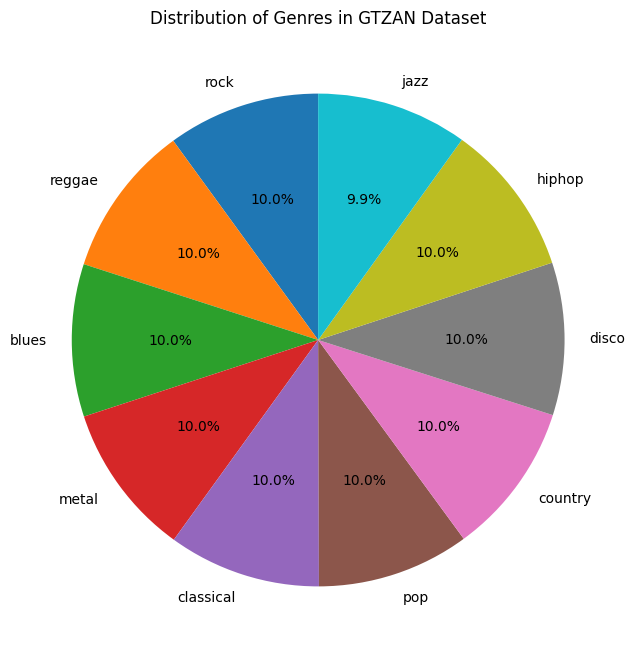

In [ ]:
value_counts = file_metadata['label'].value_counts()

labels = value_counts.index
sizes = value_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Genres in GTZAN Dataset")
plt.show()

In [ ]:
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print(X_train.shape, X_val.shape, X_test.shape)

(11530, 130, 40, 1) (3037, 130, 40, 1) (3798, 130, 40, 1)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model

def build_edl_model(input_shape, num_classes):
    inputs = Input(shape=(130, 40, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Reshape((x.shape[1], -1))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    evidence = Dense(num_classes, activation='softplus')(x)
    return Model(inputs, outputs=evidence)

In [ ]:
import tensorflow as tf
import numpy as np

# KL divergence between Dirichlet(alpha) and uniform prior
def kl_dirichlet(alpha):
    num_classes = tf.shape(alpha)[1]
    beta = tf.ones([1, num_classes], dtype=tf.float32)

    S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
    S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)

    lnB_alpha = (
        tf.math.lgamma(S_alpha)
        - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
    )
    lnB_beta = (
        tf.math.lgamma(S_beta)
        - tf.reduce_sum(tf.math.lgamma(beta), axis=1, keepdims=True)
    )

    digamma_alpha = tf.math.digamma(alpha)
    digamma_S_alpha = tf.math.digamma(S_alpha)

    kl = tf.reduce_sum(
        (alpha - beta) * (digamma_alpha - digamma_S_alpha),
        axis=1,
        keepdims=True
    ) + lnB_alpha - lnB_beta

    return kl  # (batch, 1)

# Evidential Deep Learning loss
def edl_loss(true, evidence, coeff=1e-2):
    if len(true.shape) > 1:
        true = tf.argmax(true, axis=1)

    true = tf.cast(true, tf.int32)

    alpha = evidence + 1.0
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)

    true_one_hot = tf.one_hot(true, depth=tf.shape(alpha)[1])

    loglikelihood = tf.reduce_sum(
        true_one_hot * (
            tf.math.log(alpha + 1e-8) - tf.math.log(S + 1e-8)
        ),
        axis=1
    )

    kld = kl_dirichlet(alpha)

    loss = -loglikelihood + coeff * kld
    return tf.reduce_mean(loss)


# Accuracy using Dirichlet mean
def edl_accuracy(y_true, evidence):
    if len(y_true.shape) > 1:
        y_true = tf.argmax(y_true, axis=1)

    alpha = evidence + 1.0
    probs = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)
    preds = tf.argmax(probs, axis=1)

    return tf.reduce_mean(
        tf.cast(tf.equal(preds, tf.cast(y_true, tf.int64)), tf.float32)
    )

In [ ]:
# Build and train model
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train_enc))

model = build_edl_model(input_shape, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y, ev: edl_loss(y, ev, coeff=1e-2),
    metrics=[edl_accuracy]
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_edl_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train_enc,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val_enc),
    callbacks=[early_stop, checkpoint]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test_enc)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 130, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 130, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 65, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 65, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,450 (708.79 KB)

 Trainable params: 181,450 (708.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - edl_accuracy: 0.2108 - loss: 2.2167
Epoch 1: val_loss improved from inf to 2.05974, saving model to best_edl_model.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 86s 228ms/step - edl_accuracy: 0.2109 - loss: 2.2165 - val_edl_accuracy: 0.3720 - val_loss: 2.0597
Epoch 2/40


/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y, ev: edl_loss(y, ev, coeff=1e-2),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - edl_accuracy: 0.3316 - loss: 2.0345
Epoch 2: val_loss improved from 2.05974 to 1.97864, saving model to best_edl_model.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 146s 239ms/step - edl_accuracy: 0.3317 - loss: 2.0345 - val_edl_accuracy: 0.4106 - val_loss: 1.9786
Epoch 3/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - edl_accuracy: 0.3773 - loss: 1.9472
Epoch 3: val_loss improved from 1.97864 to 1.88076, saving model to best_edl_model.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - edl_accuracy: 0.3774 - loss: 1.9472 - val_edl_accuracy: 0.4250 - val_loss: 1.8808
Epoch 4/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - edl_accuracy: 0.3997 - loss: 1.8786
Epoch 4: val_loss improved from 1.88076 to 1.82835, saving model to best_edl_model.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 85s 236ms/step - edl_accuracy: 0.3998 - loss: 1.8786 - val_edl_accuracy: 0.4566 - val_loss: 1.8283
Epoch 5/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - edl_accuracy: 0.4241 - loss

119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step


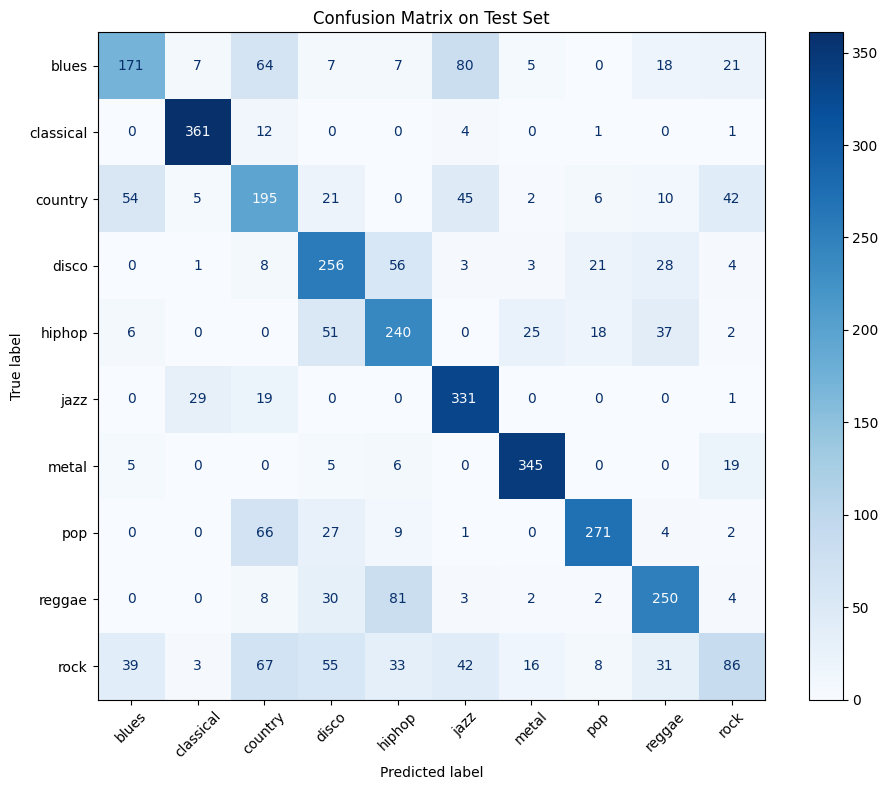

Classification Report:

              precision    recall  f1-score   support

       blues       0.62      0.45      0.52       380
   classical       0.89      0.95      0.92       379
     country       0.44      0.51      0.48       380
       disco       0.57      0.67      0.62       380
      hiphop       0.56      0.63      0.59       379
        jazz       0.65      0.87      0.74       380
       metal       0.87      0.91      0.89       380
         pop       0.83      0.71      0.77       380
      reggae       0.66      0.66      0.66       380
        rock       0.47      0.23      0.31       380

    accuracy                           0.66      3798
   macro avg       0.66      0.66      0.65      3798
weighted avg       0.66      0.66      0.65      3798



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_evidence = model.predict(X_test)
y_pred = np.argmax(y_pred_evidence, axis=1)
y_true = y_test_enc

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)
print("Classification Report:\n")
print(report)

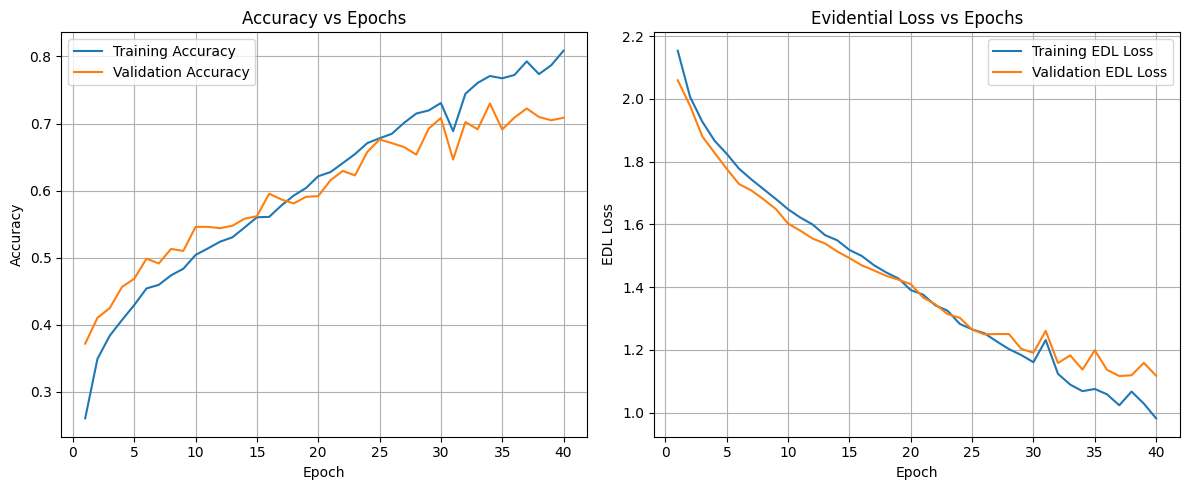

In [ ]:
import matplotlib.pyplot as plt

acc = history.history.get('edl_accuracy')
val_acc = history.history.get('val_edl_accuracy')
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training EDL Loss')
plt.plot(epochs_range, val_loss, label='Validation EDL Loss')
plt.title('Evidential Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('EDL Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def compute_uncertainty(evidence):
    """
    Compute epistemic uncertainty from Dirichlet evidence.
    Uncertainty = K / sum(alpha), where K is number of classes.
    """
    alpha = evidence + 1.0
    num_classes = alpha.shape[1]
    S = np.sum(alpha, axis=1, keepdims=True)
    uncertainty = num_classes / S
    return uncertainty.flatten()

# Predict evidences on test set
evidence = model.predict(X_test)

# Compute uncertainty
uncertainty_scores = compute_uncertainty(evidence)

# Display uncertainty for first 50 test samples
for i in range(50):
    true_label = label_encoder.inverse_transform([y_test_enc[i]])[0]
    print(
        f"Sample {i+1} — "
        f"Uncertainty: {uncertainty_scores[i]:.4f}, "
        f"True Label: {true_label}"
    )

119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step
Sample 1 — Uncertainty: 0.2815, True Label: classical
Sample 2 — Uncertainty: 0.3296, True Label: classical
Sample 3 — Uncertainty: 0.3233, True Label: classical
Sample 4 — Uncertainty: 0.3433, True Label: classical
Sample 5 — Uncertainty: 0.3617, True Label: classical
Sample 6 — Uncertainty: 0.3978, True Label: classical
Sample 7 — Uncertainty: 0.3658, True Label: classical
Sample 8 — Uncertainty: 0.3102, True Label: classical
Sample 9 — Uncertainty: 0.3208, True Label: classical
Sample 10 — Uncertainty: 0.3108, True Label: classical
Sample 11 — Uncertainty: 0.3646, True Label: classical
Sample 12 — Uncertainty: 0.2733, True Label: classical
Sample 13 — Uncertainty: 0.2800, True Label: classical
Sample 14 — Uncertainty: 0.2911, True Label: classical
Sample 15 — Uncertainty: 0.2888, True Label: classical
Sample 16 — Uncertainty: 0.3133, True Label: classical
Sample 17 — Uncertainty: 0.3989, True Label: classical
Sample 18 — Uncertainty: 0.290

In [ ]:
threshold = 0.4

# Predicted classes
predicted_classes = np.argmax(evidence, axis=1)

# Check which predictions are correct (encoded labels)
correct_mask = predicted_classes == y_test_enc

# Flag reliable predictions: correct AND below threshold
reliable_mask = (uncertainty_scores <= threshold) & correct_mask
unreliable_mask = ~reliable_mask

# Print some flagged examples
for i in range(50):
    status = "UNRELIABLE" if unreliable_mask[i] else "reliable"

    print(
        f"Sample {i+1} — Uncertainty: {uncertainty_scores[i]:.4f}, "
        f"True Label: {label_encoder.inverse_transform([y_test_enc[i]])[0]}, "
        f"Prediction: {label_encoder.inverse_transform([predicted_classes[i]])[0]} — {status}"
    )

Sample 1 — Uncertainty: 0.2815, True Label: classical, Prediction: classical — reliable
Sample 2 — Uncertainty: 0.3296, True Label: classical, Prediction: classical — reliable
Sample 3 — Uncertainty: 0.3233, True Label: classical, Prediction: classical — reliable
Sample 4 — Uncertainty: 0.3433, True Label: classical, Prediction: classical — reliable
Sample 5 — Uncertainty: 0.3617, True Label: classical, Prediction: classical — reliable
Sample 6 — Uncertainty: 0.3978, True Label: classical, Prediction: classical — reliable
Sample 7 — Uncertainty: 0.3658, True Label: classical, Prediction: classical — reliable
Sample 8 — Uncertainty: 0.3102, True Label: classical, Prediction: classical — reliable
Sample 9 — Uncertainty: 0.3208, True Label: classical, Prediction: classical — reliable
Sample 10 — Uncertainty: 0.3108, True Label: classical, Prediction: classical — reliable
Sample 11 — Uncertainty: 0.3646, True Label: classical, Prediction: classical — reliable
Sample 12 — Uncertainty: 0.273

In [ ]:
from collections import defaultdict

# Dictionary to store uncertainties per class
class_uncertainties = defaultdict(list)

# Group uncertainties by true label
for i, label in enumerate(y_test_enc):
    class_uncertainties[label].append(uncertainty_scores[i])

# Calculate and print average uncertainty for each class
print("\nAverage uncertainty per class:")
for label in sorted(class_uncertainties.keys()):
    avg_uncertainty = np.mean(class_uncertainties[label])
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"{class_name}: {avg_uncertainty:.4f}")


Average uncertainty per class:
blues: 0.4303
classical: 0.2855
country: 0.4372
disco: 0.4479
hiphop: 0.4057
jazz: 0.3973
metal: 0.3000
pop: 0.3622
reggae: 0.4207
rock: 0.4646


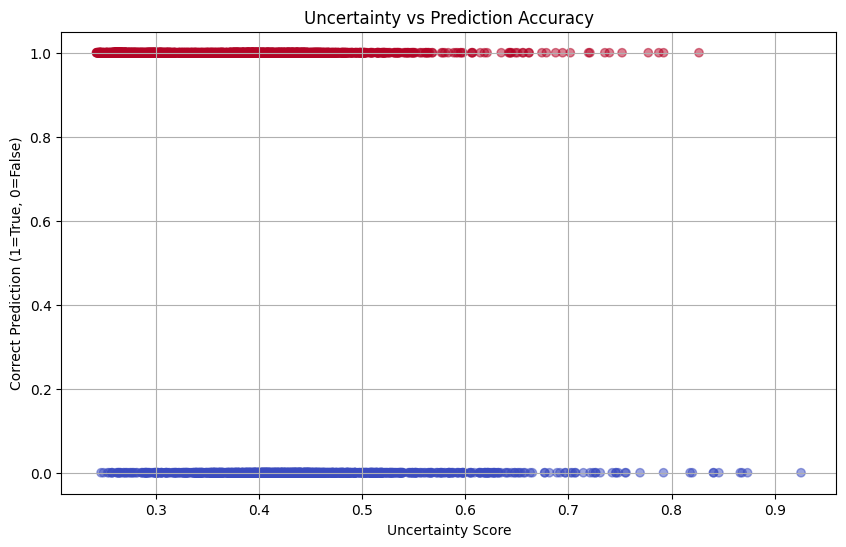

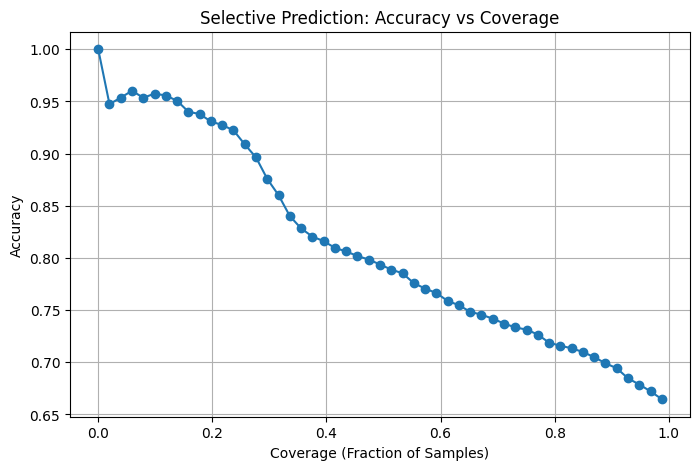

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy per sample
correct_predictions = (predicted_classes == y_test_enc)

# Scatter plot: uncertainty vs correctness
plt.figure(figsize=(10, 6))
plt.scatter(
    uncertainty_scores,
    correct_predictions.astype(int),
    alpha=0.5,
    c=correct_predictions,
    cmap='coolwarm'
)
plt.xlabel("Uncertainty Score")
plt.ylabel("Correct Prediction (1=True, 0=False)")
plt.title("Uncertainty vs Prediction Accuracy")
plt.grid(True)
plt.show()

# Sort by confidence (low uncertainty first)
sorted_indices = np.argsort(uncertainty_scores)
sorted_uncertainty = uncertainty_scores[sorted_indices]
sorted_preds = predicted_classes[sorted_indices]
sorted_true = y_test_enc[sorted_indices]

# Track coverage and accuracy
coverages = []
accuracies = []

total = len(y_test_enc)
step = max(1, total // 50)  # avoid zero step

# Selective prediction curve
for k in range(1, total + 1, step):
    selected_preds = sorted_preds[:k]
    selected_true = sorted_true[:k]

    accuracy = np.mean(selected_preds == selected_true)
    coverage = k / total

    coverages.append(coverage)
    accuracies.append(accuracy)

# Plot accuracy vs coverage
plt.figure(figsize=(8, 5))
plt.plot(coverages, accuracies, marker='o')
plt.title("Selective Prediction: Accuracy vs Coverage")
plt.xlabel("Coverage (Fraction of Samples)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
def compute_ece(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(np.max(probs, axis=1), bins) - 1
    ece = 0.0

    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.sum(bin_mask) > 0:
            bin_accuracy = np.mean(
                np.argmax(probs[bin_mask], axis=1) == labels[bin_mask]
            )
            bin_confidence = np.mean(np.max(probs[bin_mask], axis=1))
            ece += (np.sum(bin_mask) / len(labels)) * np.abs(
                bin_accuracy - bin_confidence
            )

    return ece

# Convert Dirichlet alpha to probabilities
alpha = evidence + 1.0
probs = alpha / np.sum(alpha, axis=1, keepdims=True)

# ECE
ece_score = compute_ece(probs, y_test_enc)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.1401


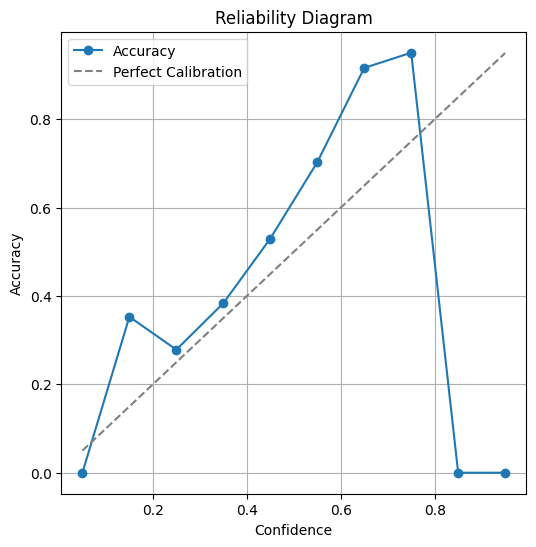

In [ ]:
def plot_reliability_diagram(probs, labels, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    accuracies = []
    confidences = []
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in range(n_bins):
        mask = (
            (np.max(probs, axis=1) > bins[i]) &
            (np.max(probs, axis=1) <= bins[i + 1])
        )

        if np.any(mask):
            acc = np.mean(
                np.argmax(probs[mask], axis=1) == labels[mask]
            )
            conf = np.mean(np.max(probs[mask], axis=1))
            accuracies.append(acc)
            confidences.append(conf)
        else:
            accuracies.append(0.0)
            confidences.append(0.0)

    plt.figure(figsize=(6, 6))
    plt.plot(bin_centers, accuracies, marker='o', label="Accuracy")
    plt.plot(
        bin_centers, bin_centers,
        linestyle='--', color='gray', label="Perfect Calibration"
    )
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot reliability diagram
plot_reliability_diagram(probs, y_test_enc)

95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
Optimal temperature (ECE-based): 0.6399
Expected Calibration Error (ECE) after temperature scaling: 0.0791


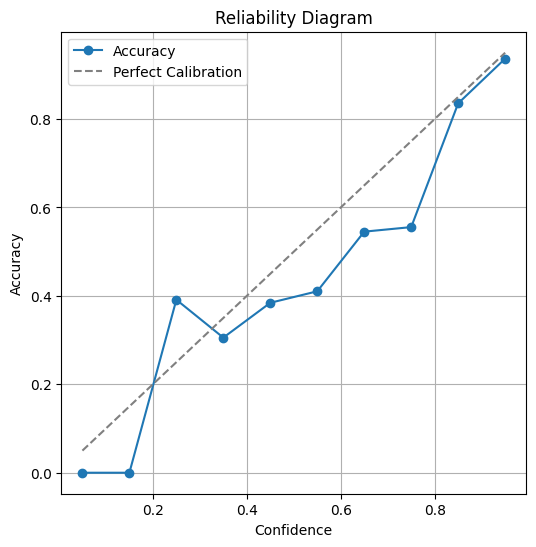

In [ ]:
import numpy as np
from scipy.optimize import minimize_scalar

val_evidence = model.predict(X_val)

# Dirichlet mean probabilities
val_alpha = val_evidence + 1.0
val_probs = val_alpha / np.sum(val_alpha, axis=1, keepdims=True)

# Temperature scaling (logit-level)
def temperature_scale(probs, temperature):
    """
    Applies temperature scaling on logits (log-space),
    followed by softmax normalization.
    """
    logits = np.log(probs + 1e-12)          # logits
    scaled_logits = logits / temperature    # temperature scaling
    exp_logits = np.exp(scaled_logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

# Optimize temperature using validation ECE
def ece_loss(temp, probs, labels):
    scaled_probs = temperature_scale(probs, temp)
    return compute_ece(scaled_probs, labels)

res = minimize_scalar(
    lambda t: ece_loss(t, val_probs, y_val_enc),
    bounds=(0.5, 5.0),
    method="bounded"
)

optimal_temp = res.x
print(f"Optimal temperature (ECE-based): {optimal_temp:.4f}")

# Apply temperature scaling on test set
test_calibrated_probs = temperature_scale(probs, optimal_temp)

ece_score_calibrated = compute_ece(test_calibrated_probs, y_test_enc)
print(f"Expected Calibration Error (ECE) after temperature scaling: {ece_score_calibrated:.4f}")

# Reliability diagram (calibrated)
plot_reliability_diagram(test_calibrated_probs, y_test_enc)

In [ ]:
calibrated_uncertainty_scores = 1 - np.max(test_calibrated_probs, axis=1)
threshold = 0.4

# Predicted classes
predicted_classes = np.argmax(evidence, axis=1)

# Compare predictions with true labels
correct_mask = predicted_classes == y_test_enc

reliable_mask = (calibrated_uncertainty_scores <= threshold) & correct_mask
unreliable_mask = ~reliable_mask

# Print flagged examples
for i in range(50):
    status = "UNRELIABLE" if unreliable_mask[i] else "reliable"
    print(
        f"Sample {i+1} — Uncertainty: {calibrated_uncertainty_scores[i]:.4f}, "
        f"True Label: {label_encoder.inverse_transform([y_test_enc[i]])[0]}, "
        f"Prediction: {label_encoder.inverse_transform([predicted_classes[i]])[0]} — {status}"
    )

Sample 1 — Uncertainty: 0.1912, True Label: classical, Prediction: classical — reliable
Sample 2 — Uncertainty: 0.3406, True Label: classical, Prediction: classical — reliable
Sample 3 — Uncertainty: 0.2935, True Label: classical, Prediction: classical — reliable
Sample 4 — Uncertainty: 0.2307, True Label: classical, Prediction: classical — reliable
Sample 5 — Uncertainty: 0.2846, True Label: classical, Prediction: classical — reliable
Sample 6 — Uncertainty: 0.3329, True Label: classical, Prediction: classical — reliable
Sample 7 — Uncertainty: 0.1373, True Label: classical, Prediction: classical — reliable
Sample 8 — Uncertainty: 0.1387, True Label: classical, Prediction: classical — reliable
Sample 9 — Uncertainty: 0.2066, True Label: classical, Prediction: classical — reliable
Sample 10 — Uncertainty: 0.1964, True Label: classical, Prediction: classical — reliable
Sample 11 — Uncertainty: 0.1760, True Label: classical, Prediction: classical — reliable
Sample 12 — Uncertainty: 0.193

In [ ]:
from collections import defaultdict
import numpy as np

# Dictionary to store calibrated uncertainties per class
class_uncertainties_calibrated = defaultdict(list)

# Group uncertainties by TRUE encoded label
for i, label in enumerate(y_test_enc):
    class_uncertainties_calibrated[label].append(
        calibrated_uncertainty_scores[i]
    )

print("\nAverage calibrated uncertainty per class:")
for label in sorted(class_uncertainties_calibrated.keys()):
    avg_uncertainty_calibrated = np.mean(
        class_uncertainties_calibrated[label]
    )
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"{class_name}: {avg_uncertainty_calibrated:.4f}")


Average calibrated uncertainty per class:
blues: 0.3693
classical: 0.1565
country: 0.3510
disco: 0.2593
hiphop: 0.3144
jazz: 0.1927
metal: 0.1053
pop: 0.1768
reggae: 0.3349
rock: 0.3861


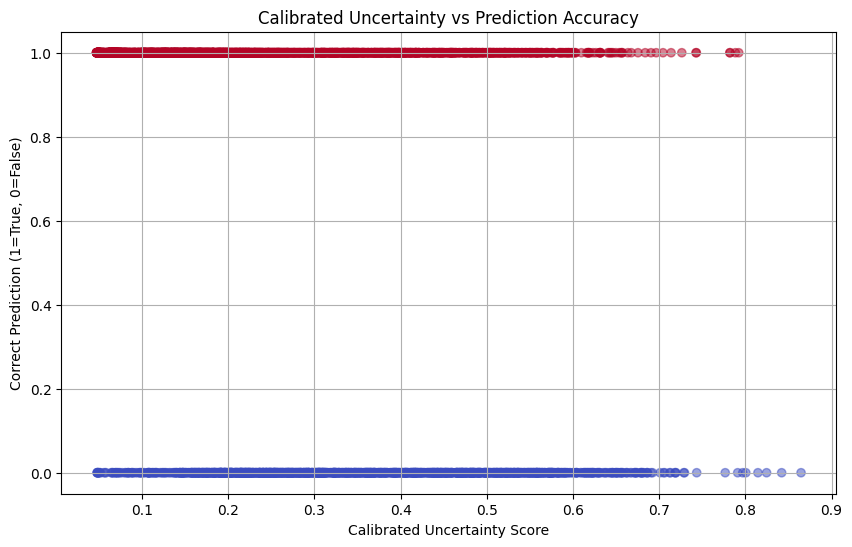

In [ ]:
correct_predictions = (predicted_classes == y_test_enc).astype(int)

plt.figure(figsize=(10, 6))
plt.scatter(
    calibrated_uncertainty_scores,
    correct_predictions,
    alpha=0.5,
    c=correct_predictions,
    cmap='coolwarm'
)
plt.xlabel("Calibrated Uncertainty Score")
plt.ylabel("Correct Prediction (1=True, 0=False)")
plt.title("Calibrated Uncertainty vs Prediction Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# Sort by confidence
sorted_indices_calibrated = np.argsort(calibrated_uncertainty_scores)
sorted_uncertainty_calibrated = calibrated_uncertainty_scores[sorted_indices_calibrated]
sorted_preds_calibrated = predicted_classes[sorted_indices_calibrated]
sorted_true_calibrated = y_test_enc[sorted_indices_calibrated]

# Track coverage and accuracy
coverages_calibrated = []
accuracies_calibrated = []

total = len(y_test_enc)
step = max(1, total // 50)

# Iterate over thresholds (from most confident to all)
for k in range(1, total + 1, step):
    selected_preds_calibrated = sorted_preds_calibrated[:k]
    selected_true_calibrated = sorted_true_calibrated[:k]

    accuracy_calibrated = np.mean(
        selected_preds_calibrated == selected_true_calibrated
    )
    coverage_calibrated = k / total

    coverages_calibrated.append(coverage_calibrated)
    accuracies_calibrated.append(accuracy_calibrated)

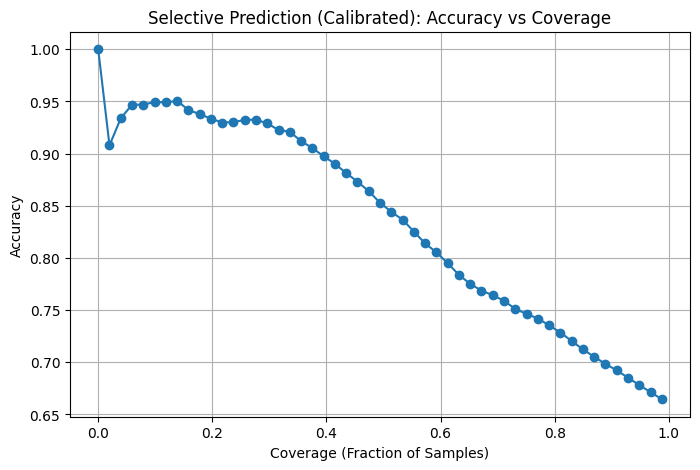

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(coverages_calibrated, accuracies_calibrated, marker='o')
plt.title("Selective Prediction (Calibrated): Accuracy vs Coverage")
plt.xlabel("Coverage (Fraction of Samples)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import wilcoxon
import numpy as np

ece_before = compute_ece(probs, y_test_enc, n_bins=10)
ece_after  = compute_ece(test_calibrated_probs, y_test_enc, n_bins=10)

print(f"ECE before calibration: {ece_before:.6f}")
print(f"ECE after calibration:  {ece_after:.6f}")

# Bootstrap for CI of difference
n_bootstrap = 1000
rng = np.random.default_rng(12345)
N = len(y_test_enc)
diffs = []

for _ in range(n_bootstrap):
    idx = rng.integers(0, N, size=N)
    ece_b = compute_ece(probs[idx], y_test_enc[idx], n_bins=10)
    ece_a = compute_ece(test_calibrated_probs[idx], y_test_enc[idx], n_bins=10)
    diffs.append(ece_b - ece_a)

diffs = np.array(diffs)
ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

print(f"Mean difference (before - after): {diffs.mean():.6f}")
print(f"95% bootstrap CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(
    "Proportion of bootstrap samples with ECE_before > ECE_after: "
    f"{(diffs > 0).mean():.3f}"
)

# Wilcoxon signed-rank test
w_stat, w_p = wilcoxon(diffs)

print(f"Wilcoxon statistic = {w_stat:.4f}, p-value = {w_p:.6e}")

if w_p < 0.05:
    print("Wilcoxon: significant reduction in ECE after calibration")
else:
    print("Wilcoxon: no significant change in ECE")

ECE before calibration: 0.140058
ECE after calibration:  0.079078
Mean difference (before - after): 0.060845
95% bootstrap CI: [0.034680, 0.087250]
Proportion of bootstrap samples with ECE_before > ECE_after: 1.000
Wilcoxon statistic = 0.0000, p-value = 3.325859e-165
Wilcoxon: significant reduction in ECE after calibration
